In [1]:
import tensorflow as tf
print(tf.__version__)


2.4.0


In [2]:
# import libraries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

# library for train test split
from sklearn.model_selection import train_test_split

# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

In [3]:
url = 'https://raw.githubusercontent.com/ShresthaSudip/SMS_Spam_Detection_DNN_LSTM_BiLSTM/master/SMSSpamCollection'
messages = pd.read_csv(url, sep ='\t',names=["label", "message"])
messages[:3]

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [4]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


## Duplicates 

In [5]:
duplicatedRow = messages[messages.duplicated()]
duplicatedRow.count()

label      403
message    403
dtype: int64

## Most repeated ham and spam messages

In [6]:
messages.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

## Exploring imbalance

In [4]:
# Get all the ham and spam emails
ham_msg = messages[messages.label =='ham']
spam_msg = messages[messages.label=='spam']

# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())

## Word cloud of Ham messages

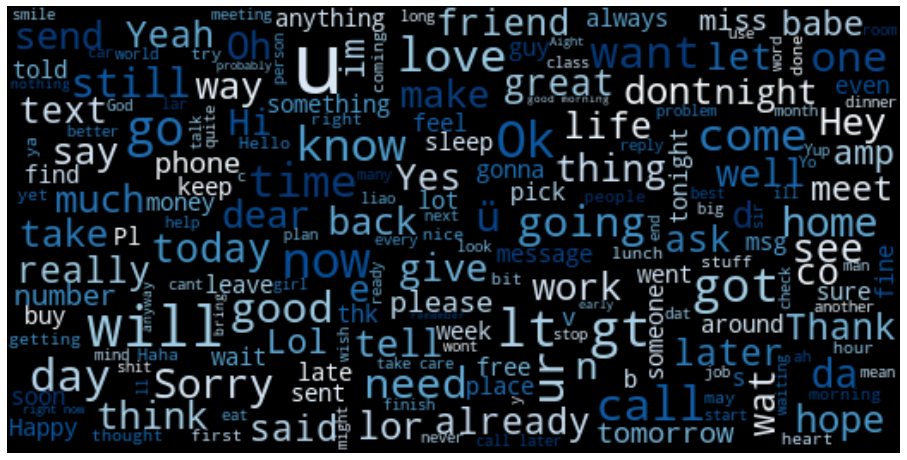

In [5]:
# wordcloud of ham messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

## Word cloud of Spam messages

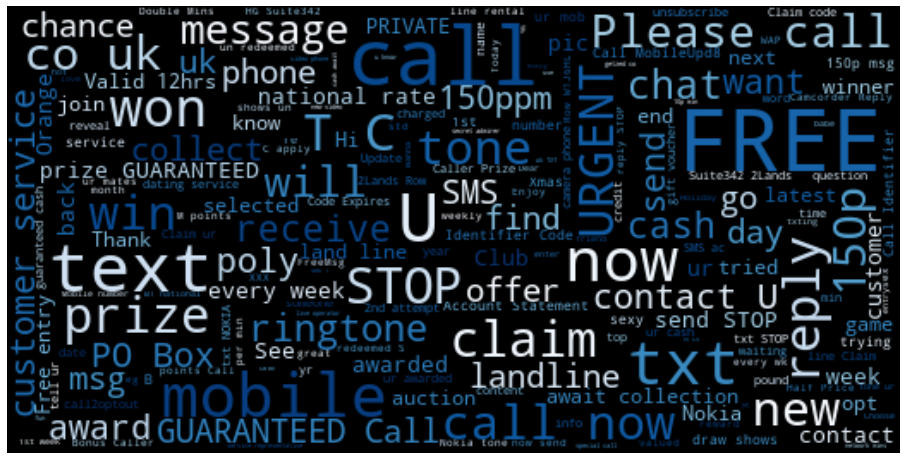

In [6]:
# wordcloud of spam messages
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

c:\python\python36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


15.481865284974095

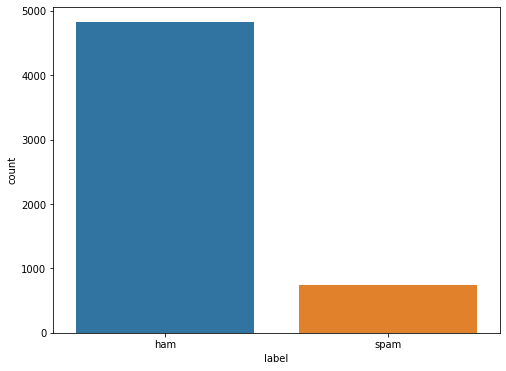

In [10]:
# we can observe imbalance data here 
plt.figure(figsize=(8,6))
sns.countplot(messages.label)
# Percentage of spam messages
(len(spam_msg)/len(ham_msg))*100 # 15.48%

## Handling imbalance using downsampling

In [7]:
# one way to fix it is to downsample the ham msg
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg
print(ham_msg_df.shape, spam_msg_df.shape)

(747, 2) (747, 2)


c:\python\python36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Message types')

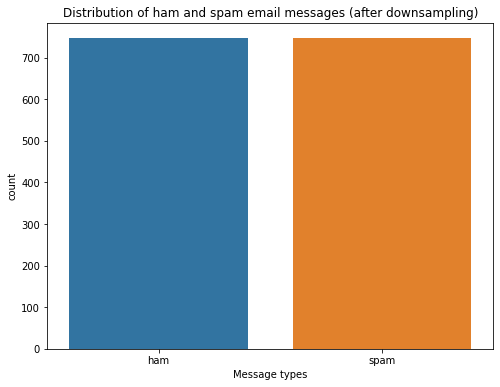

In [8]:
# Create a dataframe with these ham and spam msg
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.countplot(msg_df.label)
plt.title('Distribution of ham and spam email messages (after downsampling)')
plt.xlabel('Message types')

## Average length of msgs of both categories

In [9]:
# Get length column for each text
msg_df['text_length'] = msg_df['message'].apply(len)
#Calculate average length by label types
labels = msg_df.groupby('label').mean()
labels

,text_length
label,
ham,73.238286
spam,138.670683


## Pre-processing

In [10]:
# Map ham label as 0 and spam as 1
msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values

# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'], msg_label, test_size=0.2, random_state=434)

## defining pre processing parameters

In [11]:
# Defining pre-processing hyperparameters
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 500

## Tokenization - converting words into numeric value

In [12]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [13]:
import io
import json
tokenizer_json = tokenizer.to_json() 

with io.open('tokenizer.json', 'w', encoding='utf-8') as f:  

      f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [14]:
from keras_preprocessing.text import tokenizer_from_json
with open('tokenizer.json') as f: 

        data = json.load(f) 

        tokenizer = tokenizer_from_json(data)

In [17]:
# seeing the token of each word, just for understanding

In [15]:
# Get the word_index 
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'i': 5,
 'call': 6,
 'the': 7,
 'u': 8,
 'your': 9,
 'for': 10,
 'is': 11,
 '2': 12,
 'and': 13,
 'now': 14,
 'free': 15,
 'or': 16,
 'on': 17,
 'in': 18,
 'ur': 19,
 'have': 20,
 '4': 21,
 'txt': 22,
 'of': 23,
 'are': 24,
 'with': 25,
 'me': 26,
 'from': 27,
 'text': 28,
 'get': 29,
 'my': 30,
 'it': 31,
 'stop': 32,
 'just': 33,
 'mobile': 34,
 'this': 35,
 'will': 36,
 'be': 37,
 'no': 38,
 'that': 39,
 'claim': 40,
 'reply': 41,
 'can': 42,
 'so': 43,
 'send': 44,
 'www': 45,
 'we': 46,
 'only': 47,
 'our': 48,
 'not': 49,
 'out': 50,
 'at': 51,
 'do': 52,
 'if': 53,
 'prize': 54,
 'new': 55,
 'go': 56,
 'cash': 57,
 'but': 58,
 '150p': 59,
 'uk': 60,
 '1': 61,
 'nokia': 62,
 'who': 63,
 't': 64,
 'all': 65,
 'win': 66,
 'please': 67,
 'won': 68,
 'up': 69,
 'tone': 70,
 'when': 71,
 "i'm": 72,
 'week': 73,
 'been': 74,
 'what': 75,
 'msg': 76,
 '50': 77,
 'com': 78,
 'urgent': 79,
 'how': 80,
 'service': 81,
 'phone': 82,
 'time': 83,
 

In [67]:
len(word_index)

4169

## After tokenization we display msgs in numeric form, but each msgs has different length. Thus, use padding

In [16]:
#  Sequencing and padding on training and testing 
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )
testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
padding = padding_type, truncating = trunc_type)

**  length after padding **

In [17]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


## Spam detection model

** setting parametres **

In [18]:
vocab_size = 500 # As defined earlier i.e. numebr of words to be passed for training
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

** setting up architecture **

In [19]:
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

** model summary **

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            8000      
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
_________________________________________________________________


** compiling model **

In [21]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

## Training, testing, and predicting

In [22]:
# fitting a dense spam detector model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 6s - loss: 0.6860 - accuracy: 0.7707 - val_loss: 0.6765 - val_accuracy: 0.8328
Epoch 2/30
38/38 - 0s - loss: 0.6589 - accuracy: 0.8636 - val_loss: 0.6424 - val_accuracy: 0.8428
Epoch 3/30
38/38 - 0s - loss: 0.6064 - accuracy: 0.8728 - val_loss: 0.5782 - val_accuracy: 0.8528
Epoch 4/30
38/38 - 0s - loss: 0.5229 - accuracy: 0.8937 - val_loss: 0.4905 - val_accuracy: 0.8528
Epoch 5/30
38/38 - 0s - loss: 0.4239 - accuracy: 0.9013 - val_loss: 0.4007 - val_accuracy: 0.8662
Epoch 6/30
38/38 - 0s - loss: 0.3363 - accuracy: 0.9146 - val_loss: 0.3295 - val_accuracy: 0.8896
Epoch 7/30
38/38 - 0s - loss: 0.2745 - accuracy: 0.9213 - val_loss: 0.2800 - val_accuracy: 0.8930
Epoch 8/30
38/38 - 0s - loss: 0.2265 - accuracy: 0.9314 - val_loss: 0.2376 - val_accuracy: 0.9030
Epoch 9/30
38/38 - 0s - loss: 0.1935 - accuracy: 0.9448 - val_loss: 0.2049 - val_accuracy: 0.9064
Epoch 10/30
38/38 - 0s - loss: 0.1658 - accuracy: 0.9481 - val_loss: 0.1858 - val_accuracy: 0.9197
Epoch 11/30
38/38 -

In [26]:
## converting mdel to tflite format; so that we can deploy on android

In [27]:
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(model)
tfmodel=converter.convert()

# saving model
open('sms.tflite','wb').write(tfmodel)

INFO:tensorflow:Assets written to: C:\Users\kalpe\AppData\Local\Temp\tmp8233le25\assets


35932

In [45]:
#model.save_weights('./checkpoints')
model.save('my_model.h5')

** performance **

In [31]:
# Model performance on test data 
model.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 4ms/step - loss: 0.1236 - accuracy: 0.9498


[0.12364709377288818, 0.9498327970504761]

In [32]:
#  display long string 
pd.options.display.max_colwidth=100
messages[:3]

,label,message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...


## Predicting the class of a new msgs which are in our dataset

In [36]:
def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model.predict(padded))

predict_msg = ["Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
          "Ok lar... Joking wif u oni...",
          "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]
prediction_msg = predict_spam(predict_msg)
prediction_msg

array([[0.02847317],
       [0.01234949],
       [0.9995275 ]], dtype=float32)

* Thus the model predicts the class of the three entered msg as - the probability of 1st msg being spam is 1.8%, for 3rd it is 99% i.e. 3rd msg for sure is a spam! *

## for entirely new msgs

In [38]:
# The third one gives 0.99 indicating very high probabilty of spam
predict_msg = ["You are awarded a Nikon Digital Camera. Call now",
               "Call me",
          "What's up?"]
predict_spam(predict_msg)

array([[0.8794118 ],
       [0.05415815],
       [0.02772555]], dtype=float32)

In [39]:
spam=[]
for i in range(len(prediction_msg)):
    if prediction_msg[i]>=0.50:
        spam.append('spam')
    else:
        spam.append('ham')
print(spam)

['ham', 'ham', 'spam']


## Currently we've used dense model, we cuold also use LSTM or Bi-LSTM modell

In [35]:
def create_model():
    model = Sequential()
    model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(24, activation='relu'))
    model.add(Dropout(drop_value))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])
    return model

In [50]:
model1 = create_model()

In [57]:
model1.load_weights('my_model.h5')

In [59]:
def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model1.predict(padded))

predict_msg = ["You are awarded a Nikon Digital Camera. Call now",
               "Call me",
          "What's up?"]
predict_spam(predict_msg)

array([[0.9236996 ],
       [0.0478681 ],
       [0.01957101]], dtype=float32)

In [56]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 16)            8000      
_________________________________________________________________
global_average_pooling1d_3 ( (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 24)                408       
_________________________________________________________________
dropout_3 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
_________________________________________________________________
